# End-to-end regression project


Ceci est un extrait du chapitre 2 du livre d'Aurélien Géron: "Hands-On Machine Learning with Scikit-Learn and TensorFlow". Disponible sur amazon pour un tout petit prix. Et [ici](https://github.com/ageron/handson-ml) se trouve le projet github correspondant. 



Welcome to Machine Learning Housing Corp.! Your task is to predict median house values in Californian districts, given a number of features from these districts.


# Setup

In [1]:
# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)
np.set_printoptions(precision=2,linewidth=500,suppress=True)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

""" allow to work with absolute path which avoid problems """
PROJECT_ROOT_DIR="/Users/vigon/GoogleDrive/permanent/python/aleaDataSignal/data_analysis"

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Get the data

If the training set is very large, you may want to sample an exploration set, to make manipulations easy and fast. In our case, the set is quite small so you can just work directly on the full set.

In [2]:
import tarfile
from six.moves import urllib

def fetch_housing_data():
    
    """prepare the directory"""
    housing_path=os.path.join(PROJECT_ROOT_DIR,"datasets", "housing")
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
        
    """if the data already fetched we abort"""    
    tgz_path = os.path.join(housing_path, "housing.tgz")
    if os.path.isfile(tgz_path):
        print("data already fetched")
        
    else:
        "downloads the housing.tgz file"
        housing_url="https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.tgz"
        urllib.request.urlretrieve(housing_url, tgz_path)
        "extracts the housing.csv"
        housing_tgz = tarfile.open(tgz_path)
        housing_tgz.extractall(path=housing_path)
        housing_tgz.close()
        
    csv_path = os.path.join(housing_path, "housing.csv")
    print("data are here:\n",csv_path)
    return csv_path
    

In [3]:
csv_path=fetch_housing_data()
housing_0 = pd.read_csv(csv_path)

data already fetched
data are here:
 /Users/vigon/GoogleDrive/permanent/python/aleaDataSignal/data_analysis/datasets/housing/housing.csv


##  Take a Quick Look at the Data Structure  

In [4]:
housing_0.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


***A vous:***  Voyez-vous ($1\heartsuit$) des données manquantes?  Indiquez ($2\heartsuit$) les variables qualitatives et leurs valeurs? Précisez ($2\heartsuit$) en français la signification des variables. 

In [6]:
"Describtion of all numerical variables"
housing_0.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


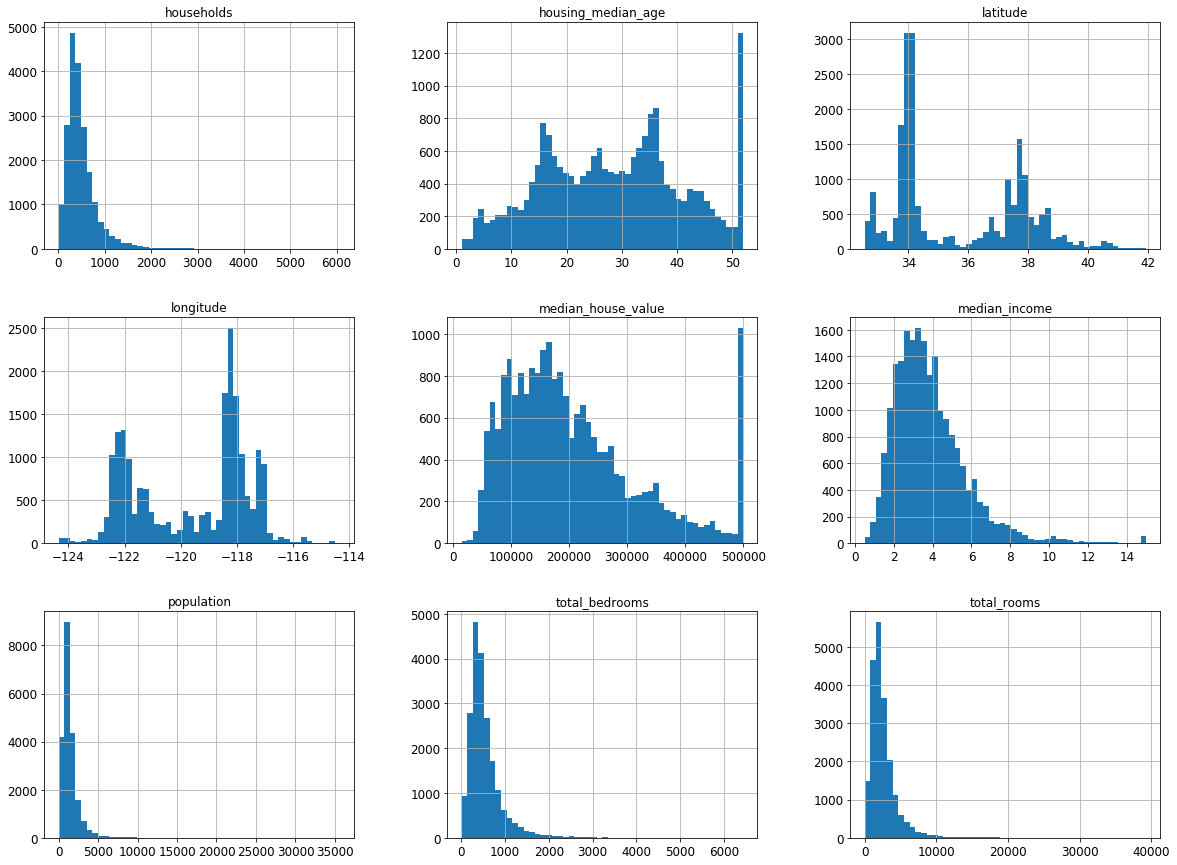

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
housing_0.hist(bins=50, figsize=(20,15));

Notice a few things in these histograms:

* First, the `median_income` attribute does not look like it is expressed in US dollars (USD). After checking with the team that collected the data, you are told that the data has been scaled and capped at 15 (actually 15.0001) for higher median incomes, and at 0.5 (actually 0.4999) for lower median incomes. Working with preprocessed attributes is common in Machine Learning, and it is not necessarily a problem, but you should try to understand how the data was computed.

* The `housing_median_age` and the `median_house_value` were also capped. The latter may be a serious problem since it is your target attribute (your labels). Your Machine Learning algorithms may learn that prices never go beyond that limit. You need to check with your client team to see if this is a problem or not. 

* Attributes have very different scales. 

* Finally, many histograms are tail heavy: they extend much farther to the right of the median than to the left. This may make it a bit harder for some Machine Learning algorithms to detect patterns. We will try transforming these attributes later on to have more bell-shaped distributions.


## Create a test set

Wait! Before you look at the data any further, you need to create a test set, put it aside, and never look at it.

You can do this later (e.g just before train models) but your human brain can also perform over-fitting when looking at data: you can choose specific algo or pre-processing: this is called the "data snooping bias". 

### First alternative: Random sampling

In [8]:
# For illustration only. Sklearn has train_test_split()
def my_split_train_test(data, test_ratio):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.loc[train_indices], data.loc[test_indices]

In [9]:
my_train_set, my_test_set = my_split_train_test(housing_0, 0.2)
print(len(my_train_set), "train +", len(my_test_set), "test")

16512 train + 4128 test


In [10]:
my_test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


In [11]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing_0, test_size=0.2, random_state=42)
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


### Stratified sampling

So far we have considered purely random sampling methods. This is generally fine if your dataset is large enough (especially relative to the number of attributes), but if it is not, you have to perform "stratified sampling": the population is divided into homogeneous subgroups called strata, and the right number of instances is sampled from each stratum to guarantee that the test set is representative of the overall population. 

Suppose you chatted with experts who told you that the median income is a very important attribute to predict median housing prices. You may want to ensure that the test set is representative of the various categories of incomes in the whole dataset. Since the median income is a continuous numerical attribute, you first need to create an income category attribute. Let’s look at the median income histogram more closely.  

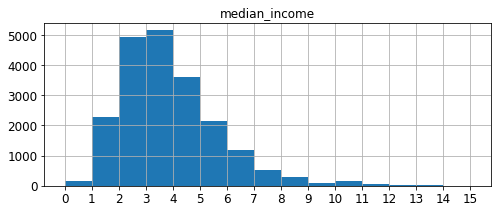

In [12]:
"""ici on améliore la méthode par défaut: housing_0["median_income"].hist()"""
data=housing_0["median_income"].values
fig,ax=plt.subplots(1,1,figsize=(8,3))
bins=np.arange(0,np.max(data),1)
ax.hist(data,bins=bins)
ax.set_xticks(bins)
ax.set_title("median_income")
ax.grid(True);

Most median income values are clustered around 2–5, but some median incomes go far beyond 6. It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate of the stratum’s importance may be biased. This means that you should not have too many strata, and each stratum should be large enough. The following code creates an income category attribute.

***A vous:***  Expliquez $(3\heartsuit)$ comment les catégories sont faites.   

In [13]:
housing_0["income_cat"] = np.ceil(housing_0["median_income"] / 1.5)
housing_0["income_cat"].where(housing_0["income_cat"] < 5, 5.0, inplace=True)

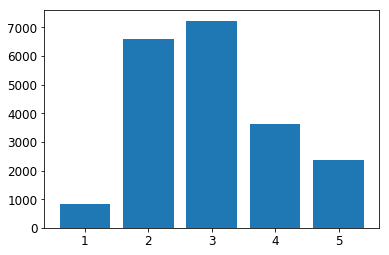

In [14]:
"""ici on améliore la méthode par défaut: housing_0["income_cat"].hist()"""
freq=housing_0["income_cat"].value_counts()
# ou bien avec numpy
# freq=np.unique(housing_0["income_cat"].values,return_counts=True)
plt.bar(freq.index,freq.values);

***A vous:*** Pourquoi $(1\heartsuit)$ on n'a pas utiliser la même technique pour tracer les histogrammes des variables `income_cat` et  `median_income`?

In [15]:
""" stratified sampling using sklearn"""
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing_0, housing_0["income_cat"]):
    strat_train_set = housing_0.loc[train_index]
    strat_test_set = housing_0.loc[test_index]

We check that `sklearn` did its work properly. 

In [16]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [17]:
housing_0["income_cat"].value_counts() / len(housing_0)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [18]:
"we do not need 'income_cat' anymore "
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Discover and visualize the data to gain insights

In [19]:
"""we keep going with the strafied version.
We make copy, so we can come back to this point."""


housing_1 = strat_train_set.copy()
housing_1_test = strat_test_set.copy()

### geographical information

Since there is geographical information (latitude and longitude), it is a good idea to create a scatterplot of all districts to visualize the data. 

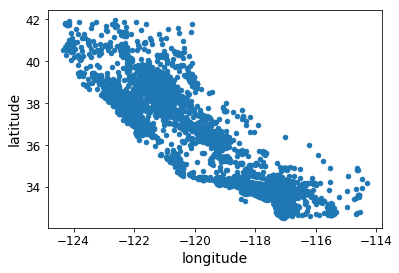

In [20]:
housing_1.plot(kind="scatter", x="longitude", y="latitude");

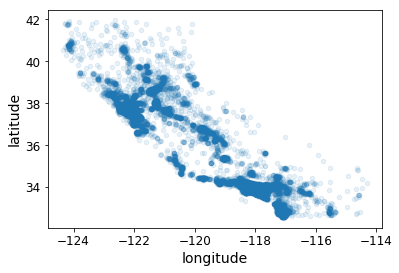

In [21]:
"better plot"
housing_1.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1);

Much better: you can clearly see the high-density areas, namely the Bay Area and around Los Angeles and San Diego, plus a long line of fairly high density in the Central Valley, in particular around Sacramento and Fresno. 

***A vous:*** Ajoutez ($4\diamondsuit$) quelques villes sur la carte.

### Housing prices

Now let’s look at the housing prices. The radius of each circle represents the district’s population (option s (size)), and the color represents the price (option c (color)). 

The argument `sharex=False` fixes a display bug (the x-axis values and legend were not displayed). This is a temporary fix.

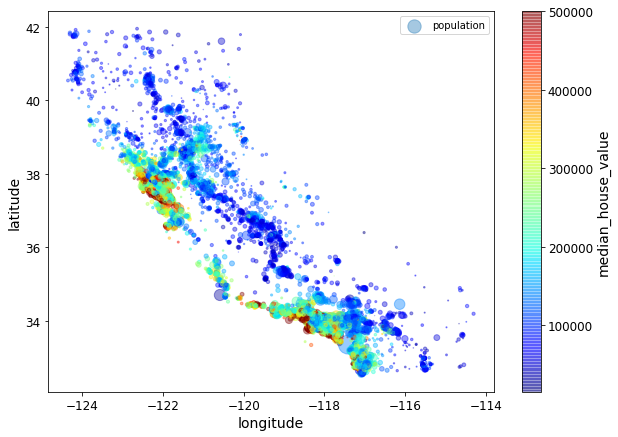

In [22]:
housing_1.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing_1["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend();

This image tells you that the housing prices are very much related to the location (e.g., close to the ocean) and to the population density, as you probably knew already. It will probably be useful to use a clustering algorithm to detect the main clusters, and add new features that measure the proximity to the cluster centers. The ocean proximity attribute may be useful as well, although in Northern California the housing prices in coastal districts are not too high, so it is not a simple rule.  

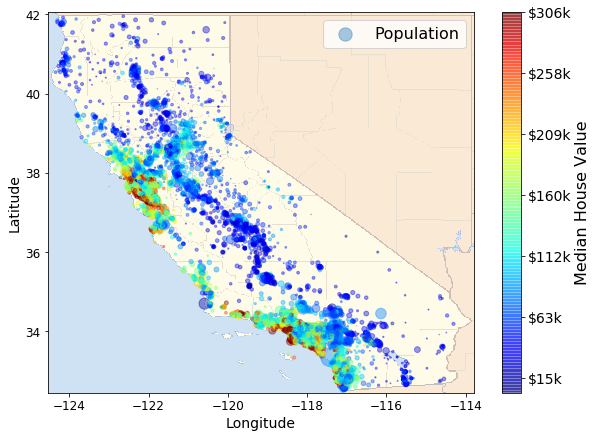

In [23]:
import matplotlib.image as mpimg
california_img=mpimg.imread(PROJECT_ROOT_DIR + '/images/california.png')
ax = housing_1.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing_1['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing_1["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16);

## Looking for Correlations

In [24]:
corr_matrix = housing_1.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


***A vous:*** Améliorez $(2\heartsuit)$ la présentation de cette matrice de corrélation pour que les principales corrélation saute aux yeux.  

***Warning:*** The correlation coefficient only measures linear correlations (“if x goes up, then y generally goes up/down”). It may completely miss out on nonlinear relationships (e.g., “if x is close to zero then y generally goes up”). 

In [25]:
"""how much each attribute correlates with the median house value"""
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Pandas’ scatter_matrix function, which plots every numerical attribute against every other numerical attribute. Since there are now 11 numerical attributes, you would get 112 = 121 plots, which would not fit on a page, so let’s just focus on a few  promising attributes that seem most correlated with the median housing value. 

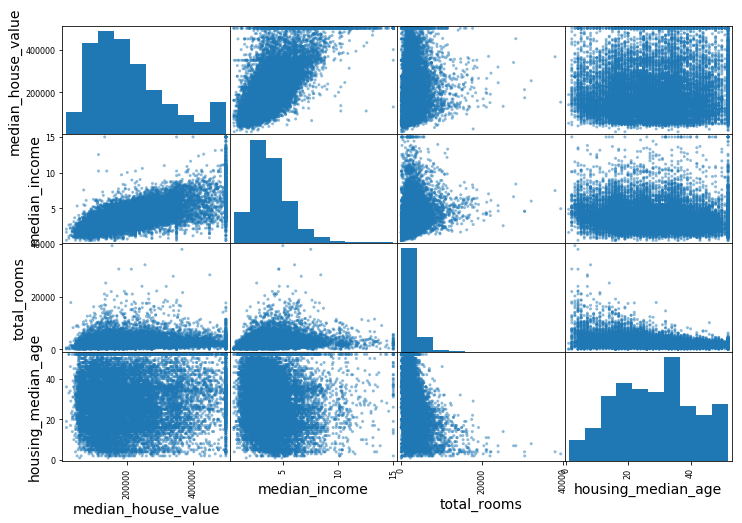

In [26]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing_1[attributes], figsize=(12, 8));

The most promising attribute to predict the median house value is the median income, so let’s zoom in on their correlation scatterplot. 

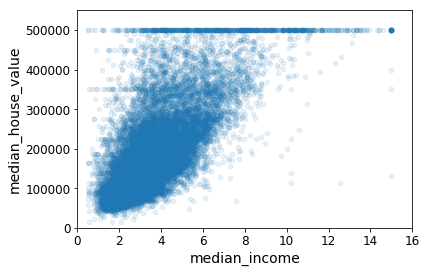

In [27]:
housing_1.plot(kind="scatter", x="median_income", y="median_house_value",alpha=0.1)
plt.axis([0, 16, 0, 550000]);

This plot reveals a few things. First, the correlation is indeed very strong; you can clearly see the upward trend and the points are not too dispersed. Second, the price cap that we noticed earlier is clearly visible as a horizontal line at \$500,000. But this plot reveals other less obvious straight lines: a horizontal line.

Around \$450,000, another around \$350,000, perhaps one around \$280,000, and a few more below that. You may want to try removing the corresponding districts to prevent your algorithms from learning to reproduce these data quirks (=bizarerie). 

## Data Cleaning

You noticed earlier that the total_bedrooms attribute has some missing values.  

In [28]:
""" lines with null values (for 'any' column)"""
housing_1[housing_1.isnull().any(axis=1)].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,175000.0,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,264400.0,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,287100.0,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,95800.0,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,191000.0,<1H OCEAN


So let’s fix this. You have three options:

* Get rid of the corresponding districts: `.dropna(subset=["total_bedrooms"])`: lazy solution.

* Get rid of the whole attribute`.drop("total_bedrooms", axis=1)`: dramatic solution.
        
* Set the values to some value (zero, the mean, the median, etc.). Good solution.

In [29]:
median = housing_1["total_bedrooms"].median()
housing_1["total_bedrooms"].fillna(median, inplace=True)

***A vous:*** 

* Vérifiez $(1\heartsuit)$ qu'il n'y a plus de valeurs manquantes
* On a nettoyé les données train. Comment $(2\heartsuit)$ pensez-vous nettoyer les données test? Il y a deux choix possible mais un seul des deux respecte la chartre de l'apprentissage: "don't touch test"
* Notre nettoyage à un inconvénient: si les données initiales sont actualisée, et qu'on veut faire foncitonner notre programme avec ces nouvelles données, le netoyage n'est pas vraiment 'automatisé' (on a regarder à la main où il y avant des Nan). Automatisez-le $(3\heartsuit)$! 
* Est-ce que $(2\diamondsuit)$ le nettoyage des données viens au bon moment dans notre analyse? ou pas?

## Creations of new natural features

In [30]:
housing_1["rooms_per_household"] = housing_1["total_rooms"]/housing_1["households"]
housing_1["bedrooms_per_room"] = housing_1["total_bedrooms"]/housing_1["total_rooms"]
housing_1["population_per_household"]=housing_1["population"]/housing_1["households"]
housing_1[["rooms_per_household","bedrooms_per_room","population_per_household"]].describe()


,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000
mean,5.440341,0.213703,3.096437
std,2.611712,0.065345,11.584826
min,1.130435,0.036980,0.692308
25%,4.442040,0.175054,2.431287
50%,5.232284,0.203059,2.817653
75%,6.056361,0.240130,3.281420
max,141.909091,2.811688,1243.333333


Now let’s look at the correlation matrix again: 

In [31]:
corr_matrix = housing_1.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047642
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.234240
Name: median_house_value, dtype: float64

Hey, not bad! The new bedrooms_per_room attribute is much more correlated with the median house value than the total number of rooms or bedrooms. Apparently houses with a lower bedroom/room ratio tend to be more expensive. The number of rooms per household is also more informative than the total number of rooms in a district — obviously the larger the houses, the more expensive they are. 

[0, 5, 0, 520000]

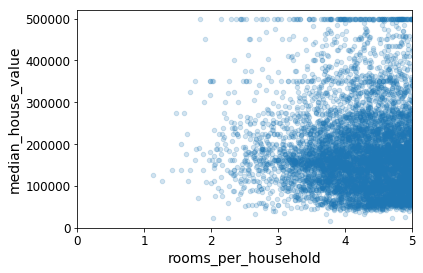

In [32]:
housing_1.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
               alpha=0.2)
plt.axis([0, 5, 0, 520000])

##  Separation of categorical/numérical, input/output

Here we create three sub-dataframe. Actually `housing_label` and `housing_cat` could also be define as Series because the has only one column.

In [33]:
housing_label = housing_1.loc[:,['median_house_value']]
housing_cat = housing_1.loc[:,['ocean_proximity']]
housing_num = housing_1.drop(['median_house_value','ocean_proximity'],axis=1,inplace=False)
print("housing_num columns\n",housing_num.columns.values)

housing_num columns
 ['longitude' 'latitude' 'housing_median_age' 'total_rooms' 'total_bedrooms' 'population' 'households' 'median_income' 'rooms_per_household' 'bedrooms_per_room' 'population_per_household']


## Categorical input feature transformation

Now let's preprocess the categorical input feature, `ocean_proximity`:

In [34]:
housing_cat['ocean_proximity'].value_counts(dropna=False)

<1H OCEAN     7276
INLAND        5263
NEAR OCEAN    2124
NEAR BAY      1847
ISLAND           2
Name: ocean_proximity, dtype: int64

In [35]:
""" sklearn method"""
from sklearn.preprocessing import LabelBinarizer
encoder=LabelBinarizer(sparse_output=False)
""" output is a numpy tensor. Keyword '1hot' recall the binarization """
X_cat_1hot=encoder.fit_transform(housing_cat)
"""we supress 'INLAND' to suppress redondance"""
X_cat_1hot=X_cat_1hot[:,[0,2,3,4]]
print("X_cat_1hot\n",X_cat_1hot[:10,:])
print("housing_cat\n",housing_cat[:10].values)
print("all classes\n",encoder.classes_)
X_cat_names=encoder.classes_[[0,2,3,4]]
print("X_cat_names\n",X_cat_names)


X_cat_1hot
 [[1 0 0 0]
 [1 0 0 0]
 [0 0 0 1]
 [0 0 0 0]
 [1 0 0 0]
 [0 0 0 0]
 [1 0 0 0]
 [0 0 0 0]
 [1 0 0 0]
 [1 0 0 0]]
housing_cat
 [['<1H OCEAN']
 ['<1H OCEAN']
 ['NEAR OCEAN']
 ['INLAND']
 ['<1H OCEAN']
 ['INLAND']
 ['<1H OCEAN']
 ['INLAND']
 ['<1H OCEAN']
 ['<1H OCEAN']]
all classes
 ['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']
X_cat_names
 ['<1H OCEAN' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


***Warning:*** Il you have categorical variables with thoushands of classes, you must use `LabelBinarizer(sparse_output=False)`. The output is then a sparse matrix of scipy.  Be be carefull: in this case, some operation further on must be adapted.  

***A vous:*** Traduisez $(1\heartsuit)$  'sparse matrix'. Comment $(1\heartsuit)$   sont-elles stockées en mémoire?

In [36]:
"""pandas method"""
pd.get_dummies(housing_cat,prefix="OP").head()

,OP_<1H OCEAN,OP_INLAND,OP_ISLAND,OP_NEAR BAY,OP_NEAR OCEAN
17606,1,0,0,0,0
18632,1,0,0,0,0
14650,0,0,0,0,1
3230,0,1,0,0,0
3555,1,0,0,0,0


With `sparse_output=True`, the output of the method `LabelBinarizer.fit_transform()`  is a SciPy sparse matrix, instead of a NumPy array. This is very useful when you have categorical attributes with thousands of categories. After one-hot encoding we get a matrix with thousands of columns, and the matrix is full of zeros except for one 1 per row. Using up tons of memory mostly to store zeros would be very wasteful. 

## Feature scaling

There are two common ways to get all attributes to have the same scale: min-max scaling and standardization. 

***Warning:*** As with all the transformations, it is important to fit the scalers to the training data only, not to the full dataset (including the test set). Only then can you use them to transform the training set and the test set (and new data).


X_num.shape (16512, 11)


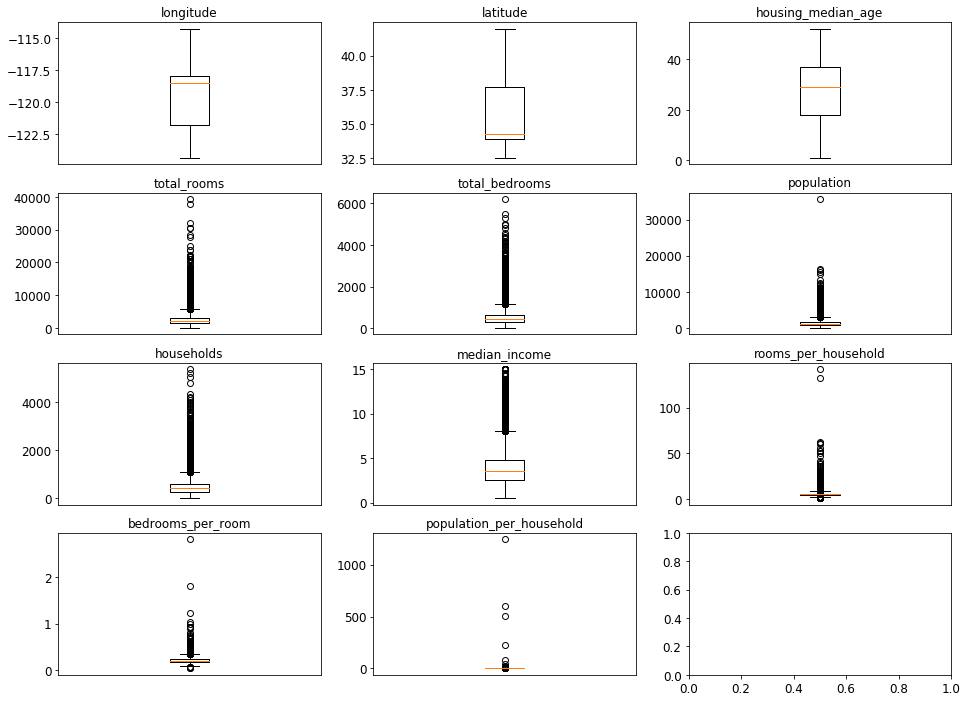

In [37]:
""" here we exit pandas."""
X_num=housing_num.values
"""be keep in memory variable names"""
X_num_names=housing_num.columns.values
print("X_num.shape",X_num.shape)
fig,axs=plt.subplots(4,3)
fig.set_size_inches(16,12)
axs_flat=axs.reshape(-1)# -> vector of Axes
for i in range(X_num.shape[1]):
    ax=axs_flat[i]
    ax.boxplot(X_num[:,i])
    ax.set_title(X_num_names[i])
    ax.set_xticks([])


In [38]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
X_num_st=scaler.fit_transform(X_num)
print("X_num_st.shape:",X_num_st.shape)

X_num_st.shape: (16512, 11)


***A vous:*** 

* Comment $(1\heartsuit)$ sont distribuées les variables après `StandardScaler.fit_transform()`
* Testez $(2\heartsuit)$ la min-max-scaling de `sklearn`.  Pour connaitre le mot clef, aidez-vous de la complétion automatique: à la suite de `from sklearn.preprocessing import StandardScaler` ajoutez une virgule, puis  tapez `Min` puis sur la touche tabulation.
* Quels sont $(3\diamondsuit)$ les avantages comparés du min-max-scaling et de la standardisation? 

## Union of all inputs

 

In [43]:
X=np.concatenate([X_num_st,X_cat_1hot],axis=1)
print("X.shape:",X.shape)

Y=housing_label.values.reshape(-1)
print("Y.shape",Y.shape)

X_names=np.concatenate([X_num_names,X_cat_names])
print("X_name\n",X_names)

X.shape: (16512, 15)
Y.shape (16512,)
X_name
 ['longitude' 'latitude' 'housing_median_age' 'total_rooms' 'total_bedrooms' 'population' 'households' 'median_income' 'rooms_per_household' 'bedrooms_per_room' 'population_per_household' '<1H OCEAN' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


***Warning for sparse matrix:***   If `X_cat_1hot` is a sparse matrix, the previous concatenation fail. You must use special operations from the `scipy` library. 

## The preprocessing pipeline

Here we are: our input `X` and our output `Y` are ready for ML algorithm. Note that here `X` and `Y` means `X_train` and `Y_train` because for a while we work with the part of data devolute to train. But  test data must also be preprocessed, with almost the same pipeline. Here we create a call `MyPipeline` gathering all our preprocessing operation. Following the `sklearn` style, the two public methods are called:

*  `fit_transform`: which will be applyed to train data
*  `transform`: which will bee applyed to test data. 

In [44]:
class MyPipeline():
        
    """this method is automaticaly called we we buid the object i.e. we write pipeline=MyPipeLine() """
    def __init__(self):
        
        self._scaler=StandardScaler()
        self._was_fit=False
        
        self.X_names=None

    
    def fit_transform(self,housing_train):
        self._was_fit=True

        self.median = housing_train["total_bedrooms"].median()
        housing_train["total_bedrooms"].fillna(self.median, inplace=True)
        self._add_features(housing_train)
            
        return self._endOfPipeline(housing_train,True)
           
       
    
    def transform(self,housing_test):
        assert self._was_fit, "please call 'fit_transform()' before 'transform()' "
        
        #do not compue median!
        housing_test["total_bedrooms"].fillna(self.median, inplace=True)
        self._add_features(housing_test)
        
        return self._endOfPipeline(housing_test,False)
        


    """ methods starting with underscore are private methods: for internal use only"""
    
    def _add_features(self,housing):
        housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
        housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
        housing["population_per_household"]=housing["population"]/housing["households"]
        
    def _endOfPipeline(self,housing,do_fit):
        housing_label = housing.loc[:,['median_house_value']]
        housing_cat = housing.loc[:,['ocean_proximity']]
        housing_num = housing.drop(['median_house_value','ocean_proximity'],axis=1,inplace=False)
        
        encoder=LabelBinarizer(sparse_output=False)
        X_cat_1hot=encoder.fit_transform(housing_cat)
        X_cat_1hot=X_cat_1hot[:,[0,2,3,4]]
        X_cat_names=encoder.classes_[[0,2,3,4]]
        
        X_num=housing_num.values
        X_num_names=housing_num.columns.values
        
        if do_fit:
            X_num_st=self._scaler.fit_transform(X_num)
        else: 
            X_num_st=self._scaler.transform(X_num)
            
            
        X=np.concatenate([X_num_st,X_cat_1hot],axis=1)
        self.X_names=np.concatenate([X_num_names,X_cat_names])
        Y=housing_label.values.reshape(-1)
        
        return X,Y
        

***A vous:*** Question d'informatique. Pourquoi ($2\heartsuit$) on n'aurait pas pu faire la même chose avec des fonctions? (par exemple une fonction `fit_transform()` et une fonction `transform()`? En répondant à cette question, vous saurez à quel moment une classe vaut mieux qu'une fonction. 

We use the pipeline to create the famous `X_train,X_test` and `Y_train,Y_test`. Because we will fit a lot of model, dans because we are in hurry, we restrict out train data. 

In [45]:
pipeLine=MyPipeline()
X_train,Y_train=pipeLine.fit_transform(housing_1)
X_test,Y_test=pipeLine.transform(housing_1_test)
X_names=pipeLine.X_names

""" we check that MyPipeline.fit_transform() make the same job as our exploratory job."""
print(X_train[:5,:])
print(X[:5,:])
print("X_names\n",X_names)

[[-1.16  0.77  0.74 -0.49 -0.45 -0.64 -0.42 -0.61 -0.31  0.16 -0.09  1.    0.    0.    0.  ]
 [-1.18  0.66 -1.17 -0.91 -1.04 -1.   -1.02  1.34  0.22 -0.84 -0.03  1.    0.    0.    0.  ]
 [ 1.19 -1.34  0.19 -0.31 -0.15 -0.43 -0.09 -0.53 -0.47  0.42 -0.09  0.    0.    0.    1.  ]
 [-0.02  0.31 -0.29 -0.36 -0.4   0.04 -0.38 -1.05 -0.08 -0.2   0.09  0.    0.    0.    0.  ]
 [ 0.49 -0.66 -0.93  1.86  2.41  2.72  2.57 -0.44 -0.36  0.27 -0.    1.    0.    0.    0.  ]]
[[-1.16  0.77  0.74 -0.49 -0.45 -0.64 -0.42 -0.61 -0.31  0.16 -0.09  1.    0.    0.    0.  ]
 [-1.18  0.66 -1.17 -0.91 -1.04 -1.   -1.02  1.34  0.22 -0.84 -0.03  1.    0.    0.    0.  ]
 [ 1.19 -1.34  0.19 -0.31 -0.15 -0.43 -0.09 -0.53 -0.47  0.42 -0.09  0.    0.    0.    1.  ]
 [-0.02  0.31 -0.29 -0.36 -0.4   0.04 -0.38 -1.05 -0.08 -0.2   0.09  0.    0.    0.    0.  ]
 [ 0.49 -0.66 -0.93  1.86  2.41  2.72  2.57 -0.44 -0.36  0.27 -0.    1.    0.    0.    0.  ]]
X_names
 ['longitude' 'latitude' 'housing_median_age' 'total_rooms' 

In [46]:
X_train=X_train[:101,:]
Y_train=Y_train[:101]

***A vous:***  Modifiez `MyPipeline`:

* Recodez $(3\heartsuit)$ à la main la standardisation. 
* Puis faites en sorte que l'on puisse éventuellement choisir pour sclaling la standardisation (choix par défaut) ou bien la formule suivante connue sous le nom de 'tanh-estimator'
$$
\frac 12 \Big(\tanh\big( \frac{x-\bar x}{100 \sigma}\big)  +1     \Big)
$$
Remarquons que c'est un mélange entre la standardisation et un min-max (car $\tanh$ arrive toujours dans le même intervalle $[-1,1]$).

*Aide informatique:* Le nouvel objet commencera ainsi: 
```
class MyPipeline():
    def __init__(self,normalization_method="standardization"):
        self.normalization_method=normalization_method
```
Puis plus loin: `if self.normalization_method== ...` 


## Select and train a model 

Here begins the machine learning. We use algorithm with very few explanation, this will come later on.  Let's start with the simplest on them:

### Linear model

In [50]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)
Y_train_hat=lin_reg.predict(X_train);

We use `pandas` just to well present numbers.

In [51]:
import pandas as pd

def present_result(nb=10):
    df=pd.DataFrame({
        "Y_train_hat":np.round(Y_train_hat[:nb]),
        "Y_train":Y_train[:nb]
    })
    return df

present_result()

,Y_train_hat,Y_train
0,200406.0,286600.0
1,297454.0,340600.0
2,152724.0,196900.0
3,71348.0,46300.0
4,203293.0,254500.0
5,139548.0,127900.0
6,383556.0,500001.0
7,187412.0,140200.0
8,156743.0,95000.0
9,354051.0,500001.0


In [49]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def show_metrics():
    """mean square error"""
    mse = mean_squared_error(Y_train, Y_train_hat)
    """root mean square error"""
    rmse = np.sqrt(mse)
    """mean absolute error """
    mae = mean_absolute_error(Y_train, Y_train_hat)

    print("lin_rmse:",rmse)
    print("lin_mae:",mae)
    
show_metrics()

lin_rmse: 68236.20454820241
lin_mae: 52871.5648390837


***A vous:*** Recalculez $(2\heartsuit)$ la MSE et MAE avec `numpy` sans utiliser `sklearn`. Laquelle $(1\heartsuit)$ de ces deux metriques est la plus sévère avec les grosses erreurs; notamment les erreur provenant de valeurs abhérante? 

### Decision Tree

In [56]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, Y_train)
Y_train_hat=tree_reg.predict(X_train)

present_result()

,Y_train_hat,Y_train
0,286600.0,286600.0
1,340600.0,340600.0
2,196900.0,196900.0
3,46300.0,46300.0
4,254500.0,254500.0
5,127900.0,127900.0
6,500001.0,500001.0
7,140200.0,140200.0
8,95000.0,95000.0
9,500001.0,500001.0


In [57]:
show_metrics()

lin_rmse: 0.0
lin_mae: 0.0


« Wait, what!? No error at all? Could this model really be absolutely perfect? Of course, it is much more likely that the model has badly overfit the data. How can you be sure? look at the test data set? No, forbidden: we want to keep it to our final step.   So we have to Solutions: 

* Simple validation: at the very beginning we separate the data into three disjoints parts train/validation/test
* Cross validation...

### Cross validation

It splits the training set into 10 distinct subsets called folds, then it trains and evaluates the model 10 times, picking a different fold for evaluation every time and training on the other 9 folds.  

In [88]:
def my_cross_validation(model,X_train,Y_train,nbFolds=10,score_choice="mae", verbose=False):   
    
    n=X_train.shape[0] #nb line
    q=X_train.shape[1] #nb variables
    quotient=n//nbFolds
    remainder=n%nbFolds
    X_fold=X_train[:-remainder,:].reshape([nbFolds,quotient,q])
    Y_fold=Y_train[:-remainder].reshape([nbFolds,quotient])
    
    scores=np.zeros(nbFolds)
        
    for i in range(nbFolds):
        if verbose: print("cross validation, fold:",i)
        all_but_i=[k for k in range(nbFolds) if k !=i]
        X=np.concatenate(X_fold[all_but_i,:,:],axis=0)
        Y=np.concatenate(Y_fold[all_but_i,:],axis=0)
        model.fit(X,Y)
        Y_hat_i=model.predict(X_fold[i,:,:])
        
        
        if score_choice=="mae":
            scores[i]=np.mean(np.abs((Y_fold[i,:]-Y_hat_i)))
        elif score_choice=="rmse":
            scores[i]=np.sqrt(np.mean((Y_fold[i,:]-Y_hat_i)**2))
        elif score_choice=="mse":
            scores[i]=np.mean((Y_fold[i,:]-Y_hat_i)**2)
        else : raise Exception("score_choice can be 'mae' or 'rmse' or 'mse' ")
        
    return scores
  

In [89]:
print("LINEAR REGRESSION")
scores=my_cross_validation(lin_reg,X_train,Y_train,nbFolds=10,score_choice="mae")
print("bias:",np.mean(scores))
print("variance:",np.std(scores))

LINEAR REGRESSION
bias: 67594.51141858901
variance: 20331.259962012486


In [90]:
print("DECISSION TREE")
scores=my_cross_validation(tree_reg,X_train,Y_train,10)
print("bias:",np.mean(scores))
print("variance:",np.std(scores))

DECISSION TREE
bias: 72149.07
variance: 23419.971254126256


Note that cross validation also allow to estimate "variability" of our model. While simple validation only give you the bias.  

***A vous:*** Rappelez $(2\diamondsuit)$ avec vos propres mots, en deux ou trois lignes, ce qu'est que signifie 'biais' et 'variance' dans ce contexte.  

Here is the `sklearn` process do make cross validation.

***Warning:***  it expect a utility function (greater is better) rather than a cost function (lower is better), so the scoring function is actually the opposite of the MSE. 

In [92]:
from sklearn.model_selection import cross_val_score
scores = -cross_val_score(tree_reg, X_train, Y_train,scoring="neg_mean_absolute_error", cv=10)
print("DECISSION TREE, CV WITH SKLEARN")
print("mean score:",np.mean(scores))
print("sdt score:",np.std(scores))

DECISSION TREE, CV WITH SKLEARN
mean score: 69739.2509090909
sdt score: 31478.26709092623


Let's try random Forests: it works by training many Decision Trees on random subsets of the features, then averaging out their predictions. Building a model on top of many other models is called Ensemble Learning, and it is often a great way to push ML algorithms even further. 

### Random forest

In [93]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(random_state=42,n_estimators=6,max_features=6)
scores_rmse=my_cross_validation(forest_reg,X_train,Y_train,10)
print("RANDOM FOREST")
print("mean rmse:",np.mean(scores_rmse))
print("sdt rmse:",np.std(scores_rmse))

RANDOM FOREST
mean rmse: 64243.74166666666
sdt rmse: 24429.2834853313


Random Forests look  promising.  However, before you dive much deeper in Random Forests, you should try out many other models from various categories of Machine Learning algorithms:

* several Support Vector Machines with different kernels
* a neural network, etc.,

without spending too much time tweaking the hyperparameters. The goal is to shortlist a few (two to five) promising models.

***A vous:*** Essayez $(2\heartsuit)$ un SVM linéaire. Testez $(2\heartsuit)$ aussi un autre noyaux (allez voir l'aide sur internet). Voici le début. 

In [94]:
from sklearn.svm import SVR
svm_reg = SVR(kernel="linear")

## Fine-Tune Your Model

Let’s assume that we now have a shortlist of promising models. We now need to find the best set of hyper-parameters.  

### Grid search (=quadrillage)

We fine tune the Random Forest Model. Its hyper-parameters are 'bootstrap','n_estimators' and 'max_features' (we will explain them further on).  For each parameter we choose some values, and then try all possible combinaisons of these values. 

In [95]:
"to try 1*2*2 combinations of hyperparameters (to debug fastly)"
#param_grid = {'bootstrap': [True],'n_estimators': [3, 10], 'max_features': [2, 4]}
"to try 2*3*4 combinations of hyperparameters (less fastly)"
param_grid = {'bootstrap': [True,False],'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}
  
results=[]
for bootstrap in param_grid['bootstrap']:
    for n_estimators in param_grid['n_estimators']:
        for max_features in param_grid['max_features']:
            
            forest_reg = RandomForestRegressor(
                random_state=42,
                bootstrap=bootstrap,
                n_estimators=n_estimators,
                max_features=max_features
            )
            
            scores_rmse=my_cross_validation(forest_reg,X_train,Y_train,10)
            
            results.append({
                "bias": np.round(np.mean(scores_rmse)),
                "std" : np.round(np.std(scores_rmse)),
                "bootstrap":bootstrap,
                "n_estimators":n_estimators,
                "max_features":max_features
            })

results.sort(key=lambda elem: elem["bias"])
# ou bien 
# results_sorted=sorted(results,key=lambda elem: elem["bias"])
pd.DataFrame(results[:10])

,bias,bootstrap,max_features,n_estimators,std
0,54982.0,False,6,10,20489.0
1,56569.0,False,6,30,22597.0
2,59328.0,True,6,30,23621.0
3,60644.0,True,6,10,24159.0
4,60668.0,True,4,30,26139.0
5,60724.0,True,8,30,27910.0
6,60868.0,False,8,30,23395.0
7,61073.0,False,4,30,24911.0
8,61137.0,False,6,3,17641.0
9,63357.0,False,8,10,21412.0


### Random Search

We try a fixe number of random combinaisons of hyper-parameters. It is not obligatory to choose uniform distributions.

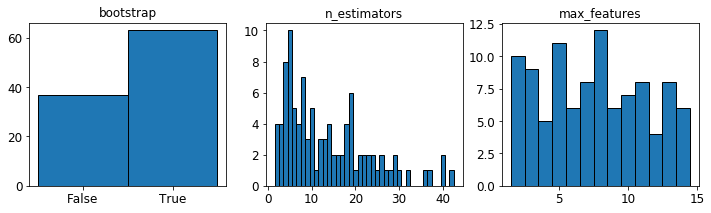

In [96]:
size=100

n_estimators=2+np.floor(np.random.chisquare(3,size=size)*4).astype(np.int)
bootstrap=np.random.choice(a=[True,False],p=[2/3,1/3],size=size)
max_features=np.random.randint(2,X_test.shape[1],size=size)


fig,(ax0,ax1,ax2)=plt.subplots(1,3,figsize=(12,3))

def one_discrete_hist(ax,data,title):
    freq=np.unique(data,return_counts=True)
    ax.bar(freq[0],freq[1],edgecolor="k",width=1)
    ax.set_title(title)

one_discrete_hist(ax0,bootstrap,"bootstrap")
ax0.set_xticks([0,1])
ax0.set_xticklabels(["False","True"])
one_discrete_hist(ax1,n_estimators,"n_estimators")
one_discrete_hist(ax2,max_features,"max_features")

In [97]:
results=[]
for i in range(size):
            
            forest_reg = RandomForestRegressor(
                random_state=42,
                bootstrap=bootstrap[i],
                n_estimators=n_estimators[i],
                max_features=max_features[i]
            )
            
            scores_rmse=my_cross_validation(forest_reg,X_train,Y_train,10)
            
            results.append({
                "bias": np.round(np.mean(scores_rmse)),
                "std" : np.round(np.std(scores_rmse)),
                "bootstrap":bootstrap[i],
                "n_estimators":n_estimators[i],
                "max_features":max_features[i]
            })

results.sort(key=lambda elem: elem["bias"])
# ou bien 
# results_sorted=sorted(results,key=lambda elem: elem["bias"])
pd.DataFrame(results[:10])


,bias,bootstrap,max_features,n_estimators,std
0,55245.0,False,7,40,21742.0
1,55498.0,False,7,30,20975.0
2,55738.0,False,5,24,21570.0
3,55758.0,False,5,21,22095.0
4,55983.0,False,7,42,21489.0
5,56011.0,False,5,14,22859.0
6,57413.0,False,7,19,21695.0
7,57948.0,False,6,19,22449.0
8,58411.0,False,5,4,20748.0
9,58897.0,True,14,15,25498.0


The random search give the same result that the grid search. 

### The hidden advantage of random search

Random search is necessary when you have several parameters with large range. But it has also has an hidden advantage: suppose that some parameters have few importance, like the parameter `y` in the following utility function... 

***Exo:***  Explain $(5\diamondsuit)$ why, for such an example, random search performs better for maximizing. Make a program  with comparisons. Some scatter-plots could also be illustrative.

Text(0.5,1,'log de la fonction loss')

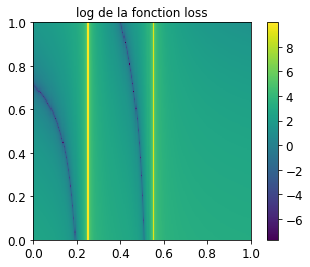

In [98]:
def utility(x,y):
    return np.abs(1/(x-0.55266)+1/(x-0.25121)+20*y)

x=np.linspace(0,1,200)
XX,YY=np.meshgrid(x,x)
plt.imshow(np.log(utility(XX,YY)),extent=[0,1,0,1])
plt.colorbar()
plt.title("log de la fonction loss")

### Fine tune not only parameters

You can treat some of the data preparation steps as hyperparameters. For example, the grid search will automatically find out whether or not to add a feature you were not sure about (e.g., using the add_bedrooms_per_room hyperparameter of your CombinedAttributesAdder transformer). It may similarly be used to automatically find the best way to handle outliers, missing features, feature selection, scaling and more. 

## Analyze the Best Models and Their Errors

You will often gain good insights on the problem by inspecting the best models. For example, the RandomForestRegressor can indicate the relative importance of each attribute for making accurate predictions. 


In [99]:
best_params=results[0]
best_params

{'bias': 55245.0,
 'std': 21742.0,
 'bootstrap': False,
 'n_estimators': 40,
 'max_features': 7}

In [100]:
best_model= RandomForestRegressor(
                random_state=42,
                bootstrap=best_params["bootstrap"],
                n_estimators=best_params["n_estimators"],
                max_features=best_params["max_features"]
            )
best_model.fit(X_train,Y_train)


RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [101]:
feature_importances=best_model.feature_importances_
named_feature_importances=[]
for i in range(len(feature_importances)):
    named_feature_importances.append((X_names[i],feature_importances[i]))
named_feature_importances.sort(key=lambda pair:-pair[1])
named_feature_importances

[('median_income', 0.3010660388841132),
 ('population_per_household', 0.15055819771645795),
 ('longitude', 0.10532626233923077),
 ('<1H OCEAN', 0.09496578397871114),
 ('rooms_per_household', 0.07444457960060272),
 ('latitude', 0.06053838269349471),
 ('bedrooms_per_room', 0.05018954115770939),
 ('housing_median_age', 0.049129605363837994),
 ('total_bedrooms', 0.04596766955109704),
 ('total_rooms', 0.026724543642347914),
 ('households', 0.020581013603319855),
 ('NEAR BAY', 0.010915050746642866),
 ('population', 0.007866980810247427),
 ('NEAR OCEAN', 0.0017263499121871213),
 ('ISLAND', 0.0)]

With this information, you may want to try dropping some of the less useful features (e.g., apparently only one ocean_proximity category is really useful, so you could try dropping the others).
You should also look at the specific errors that your system makes, then try to understand why it makes them and what could fix the problem (adding extra features or, on the contrary, getting rid of uninformative ones, cleaning up outliers, etc.)

## Evaluate Your System on the Test Set 

### Compute Y_test_hat

In [107]:
Y_test_hat=best_model.predict(X_test)
mae_test=np.mean(np.abs(Y_test-Y_test_hat))
squared_errors=(Y_test-Y_test_hat)**2

mse_test=np.mean(squared_errors)
rmse_test=np.sqrt(np.mean((Y_test-Y_test_hat)**2))
print("mae_test:",mae_test)
print("rmse_test:",rmse_test)

mae_test: 55461.58742126938
rmse_test: 78520.5857028922


### confidence interval

In [109]:
from scipy import stats

We could compute a confidence interval:

In [110]:
confidence = 0.95
m = len(Y_test)

tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mse_test - tmargin), np.sqrt(mse_test + tmargin)

(76007.39188098168, 80955.79743107567)

Alternatively, we could use a z-scores rather than t-scores:

In [111]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mse_test - zmargin), np.sqrt(mse_test + zmargin)

(76008.14112752094, 80955.09397554511)

### Model persistence

You can save the final model in order to reuse it later. 

In [112]:
from sklearn.externals import joblib
""" the file my_model.pkl contain the description of the model, and all its parameters and hyperparameters. """
joblib.dump(best_model, "my_model.pkl") 
""" and one week later: """
best_model_one_week_later = joblib.load("my_model.pkl") 
best_model_one_week_later.predict(X_test)

array([404735.53, 292625.03, 207347.5 , ..., 394035.28, 251155.  , 183342.55])

## Utilisez ces propres fonctions où des fonctions prédéfinies?

C'est un dilemme que l'on a très souvent. Dans ce tuto le choix c'est posé pour:

* Le remplacement des valeurs manquantes par la médiane d'une colonne. Nous l'avons fait à la main, on aurait put utiliser ceci:
```
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")
imputer.fit_transform(data_train)
#puis plus loin
inputer.transform(data_test)
```
* La standardisation pour laquel j'ai utilisé `sklearn` mais que je vous ai demandé de reprogrammer (avec une variante). 
* La cross-validation: Ici le programme maison n'était pas élémentaire. Mais je trouve qu'il était riche d'enseignement
* La création du pipeline. `sklearn` propose une classe qui permet d'emboiter les différents  traitements de données. Mais je trouve cela inutile.  
* La recherche en grille ou aléatoire. Encore une fois les classes `sklearn` sont à mon avis inutile. De plus on a facilement envie de se faire un process maison, mélangeant grille et aléatoire tout en alternant modèles. 

De manière générale coder les choses soi même est beaucoup plus formateur et permet plus de personnalisation.  MAIS, ne surtout pas recoder les "traitement lourds" qui demandement des optimisations, comme par exemple les différents modèles (à l'exception du modèle linéaire ou ridge qui se code en 2 lignes). 